In [28]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

In [29]:
data = pd.read_json('../input/sarcasm-detection-through-nlp/Sarcasm_Headlines_Dataset.json', lines=True)
data

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0
...,...,...,...
26704,https://www.huffingtonpost.com/entry/american-...,american politics in moral free-fall,0
26705,https://www.huffingtonpost.com/entry/americas-...,america's best 20 hikes,0
26706,https://www.huffingtonpost.com/entry/reparatio...,reparations and obama,0
26707,https://www.huffingtonpost.com/entry/israeli-b...,israeli ban targeting boycott supporters raise...,0


In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26709 entries, 0 to 26708
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   article_link  26709 non-null  object
 1   headline      26709 non-null  object
 2   is_sarcastic  26709 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 626.1+ KB


In [34]:
def get_sequences(texts, tokenizer, train = True, max_seq_length = None):
    sequences = tokenizer.texts_to_sequences(texts)
    
    if train == True:
        max_seq_length = np.max(list(map(len, sequences)))
        
    sequences = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen = max_seq_length, padding = 'post')
    
    return sequences

In [37]:
def preprocess_inputs(df):
    df = df.copy()
    df = df.drop('article_link', axis = 1)
    
    ## Split the df
    y = df['is_sarcastic']
    X = df['headline']
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True, random_state=1)
    
    ## Create and fit tokenizer
    tokenizer = tf.keras.preprocessing.text.Tokenizer()
    tokenizer.fit_on_texts(X_train)
    print('vocab length:', len(tokenizer.word_index) + 1)
    
    ## Get sequences
    X_train = get_sequences(texts = X_train, tokenizer = tokenizer, train = True)
    X_test = get_sequences(texts = X_test, tokenizer = tokenizer, train = False, max_seq_length = X_train.shape[1])
    print('Sequence length:', X_train.shape)
    print('Sequence length:', X_train.shape[1])
    
    
    return X_train, X_test, y_train, y_test

In [38]:
X_train, X_test, y_train, y_test = preprocess_inputs(data)
X_train

vocab length: 24846
Sequence length: (18696, 40)
Sequence length: 40


array([[ 3579,   481,  1858, ...,     0,     0,     0],
       [ 6496,  4001,     7, ...,     0,     0,     0],
       [ 8490,   343,    11, ...,     0,     0,     0],
       ...,
       [ 4518,  2106, 24841, ...,     0,     0,     0],
       [24843,  1042,  1441, ...,     0,     0,     0],
       [   24,     1,  5280, ...,     0,     0,     0]], dtype=int32)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 40)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 40, 64)            1590144   
_________________________________________________________________
flatten_1 (Flatten)          (None, 2560)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               327808    
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 1,934,593
Trainable params: 1,934,593
Non-trainable params: 0
_________________________________________________

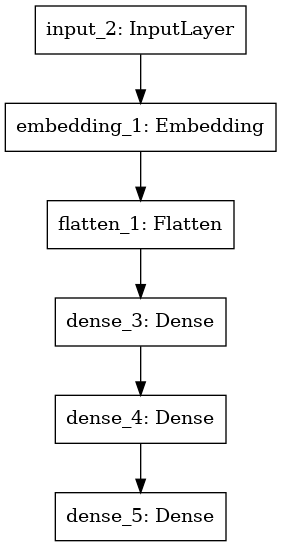

In [40]:
inputs = tf.keras.Input(shape = (40,))
x = tf.keras.layers.Embedding(
    input_dim = 24846,
    output_dim = 64
)(inputs)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation = 'relu')(x)
x = tf.keras.layers.Dense(128, activation = 'relu')(x)
outputs = tf.keras.layers.Dense(1, activation = 'sigmoid')(x)

model = tf.keras.Model(inputs = inputs, outputs = outputs)

model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = [
        'accuracy', tf.keras.metrics.AUC(name = 'auc')
    ]
)

print(model.summary())
tf.keras.utils.plot_model(model)

In [41]:
history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    batch_size=32,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

2022-12-14 05:46:31.923579: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
468/468 [==============================] - 6s 11ms/step - loss: 0.4116 - accuracy: 0.7985 - auc: 0.8899 - val_loss: 0.3275 - val_accuracy: 0.8602 - val_auc: 0.9348
Epoch 2/100
468/468 [==============================] - 5s 11ms/step - loss: 0.0946 - accuracy: 0.9664 - auc: 0.9935 - val_loss: 0.4033 - val_accuracy: 0.8508 - val_auc: 0.9250
Epoch 3/100
468/468 [==============================] - 5s 11ms/step - loss: 0.0091 - accuracy: 0.9974 - auc: 0.9997 - val_loss: 0.5472 - val_accuracy: 0.8500 - val_auc: 0.9164
Epoch 4/100
468/468 [==============================] - 5s 11ms/step - loss: 0.0011 - accuracy: 0.9999 - auc: 1.0000 - val_loss: 0.7104 - val_accuracy: 0.8465 - val_auc: 0.9049


Accuracy: 86.23%
     AUC: 0.94033


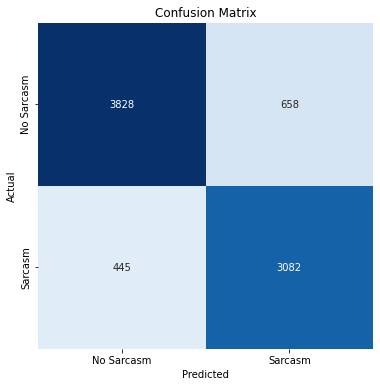

Classification Report:
----------------------
               precision    recall  f1-score   support

  No Sarcasm       0.90      0.85      0.87      4486
     Sarcasm       0.82      0.87      0.85      3527

    accuracy                           0.86      8013
   macro avg       0.86      0.86      0.86      8013
weighted avg       0.86      0.86      0.86      8013



In [43]:
results = model.evaluate(X_test, y_test, verbose=0)

print("Accuracy: {:.2f}%".format(results[1] * 100))
print("     AUC: {:.5f}".format(results[2]))

y_pred = np.squeeze(model.predict(X_test) >= 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
clr = classification_report(y_test, y_pred, labels=[0, 1], target_names=["No Sarcasm", "Sarcasm"])

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=[0.5, 1.5], labels=["No Sarcasm", "Sarcasm"])
plt.yticks(ticks=[0.5, 1.5], labels=["No Sarcasm", "Sarcasm"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)